In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sne
import IPython.display as display
import calendar

%matplotlib inline

In [2]:
coloums1=['click','hour','C1','banner_pos','site_category'
 ,'app_category','device_type','device_conn_type'
 ,'C14','C15','C16','C17','C18','C19','C20','C21']
coloums2=['device_type','device_conn_type'
 ,'C14','C15','C16','C17','C18','C19','C20','C21']

In [3]:
chunlsize=1000000
data_chunks=pd.read_csv('/home/ashwin/Downloads/clickthrough/train.csv'
                 ,chunksize=chunlsize,usecols=coloums1,nrows=1000000,
                 dtype={'click':np.int8,'hour':np.str,'C1':np.str,
                        'banner_pos':np.str,'site_category':np.str,
                        'app_category':np.str,'device_type':np.str,
                        'device_conn_type':np.str,'C14':np.str,
                        'C15':np.str,'C16':np.str,
                        'C17':np.str,'C18':np.str,'C19':np.str,
                        'C20':np.str,'C21':np.str})
df = pd.concat([chunk for chunk in data_chunks])

In [4]:
df.shape

(40428967, 6)

In [ ]:
for col in coloums:
    print "the sum of null value in",col,sum(df[col].isnull())

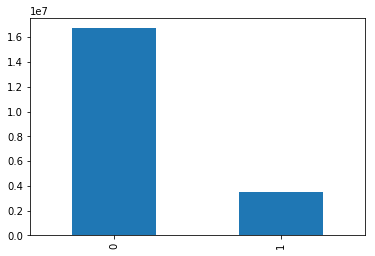

In [5]:
df['click'].value_counts().plot(kind='bar')

In [9]:
df['click'].mean()*100

16.980562476404604

In [5]:
hour=df['hour']
df.drop(['hour'],axis=1,inplace=True)

In [6]:
print hour.shape
print list(df)

In [7]:
df['year']=[np.int8('20'+x[0:2]) for x in hour]
df['month']=[np.int8(x[2:4]) for x in hour]
df['month']=df['month'].apply(lambda x: calendar.month_abbr[x])
df['day']=[np.int8(x[4:6]) for x in hour]
df['time']=[np.int8(x[6:8]) for x in hour]

In [10]:
year_dummies=pd.get_dummies(df['year'])
month_dummies=pd.get_dummies(df['month'])
day_dummies=pd.get_dummies(df['day'])
time_dummies=pd.get_dummies(df['time'])

In [11]:
df.drop(['year'],axis=1,inplace=True)
df.drop(['month'],axis=1,inplace=True)
df.drop(['day'],axis=1,inplace=True)
df.drop(['time'],axis=1,inplace=True)
list(df)

['click', 'C1', 'banner_pos', 'site_category', 'app_category']

In [12]:
C1_dummies=pd.get_dummies(df['C1'])
banner_pos_dummies=pd.get_dummies(df['banner_pos'])
site_category_dummies=pd.get_dummies(df['site_category'])
app_category_dummies=pd.get_dummies(df['app_category'])
click=df['click']

In [14]:
frame=[year_dummies,month_dummies,day_dummies,time_dummies
    ,C1_dummies,banner_pos_dummies,site_category_dummies
    ,app_category_dummies,click]
result1=pd.concat(frame)

MemoryError: 

In [ ]:
hdf =pd.HDFStore('data1.h5')
hdf.put('/home/ashwin/Downloads/clickthrough/hdf/data1', result1, format='table', data_columns=True)

In [13]:
del df
chunlsize=1000000
data_chunks=pd.read_csv('/home/ashwin/Downloads/clickthrough/train.csv'
                 ,chunksize=chunlsize,usecols=coloums2,nrows=20214484,
                 dtype={'device_type':np.int8,'device_conn_type':np.int8,'C14':np.int16,'C15':np.int16,'C16':np.int16,
'C17':np.int16,'C18':np.int8,'C19':np.int16,'C20':np.int32,'C21':np.int16})
df = pd.concat([chunk for chunk in data_chunks])

In [1]:
import os
from collections import Counter
import numpy as np
import pandas as pd

ids={}
COLS_TO_TRANLSATE = "site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model"
COLS_TO_TRANLSATE = COLS_TO_TRANLSATE.split(",") 

COLS = "id,click,day,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21"
COLS = COLS.split(",")

TRAIN_DATA = "/home/ashwin/Downloads/clickthrough/train.csv"
TEST_DATA = "/home/ashwin/Downloads/clickthrough/test.csv"
MERGED_DATA = "/home/ashwin/Downloads/clickthrough/merged.csv"

CHUNK_SIZE = 1000000

def create_counters():    
    counters = {}
    for col in COLS_TO_TRANLSATE:
        counters[col] = Counter()
    return counters
    
def update_counter(path,counters):
    df = pd.read_csv(path,chunksize=CHUNK_SIZE,iterator=True)
    for chunk in df:    
        for col in COLS_TO_TRANLSATE:
            counters[col].update(chunk.ix[:,col])
        print chunk.id.max()

def convert_counts_to_id(counters):
    #ids = {}
    for col in COLS_TO_TRANLSATE:
        ids[col] = {}
        for i,(val,_) in enumerate(counters[col].most_common()):
            ids[col][val] = i
    return ids
    
def write_translated(input_path,output_path,ids,mode="w",start_id=0):
    df = pd.read_csv(input_path,chunksize=CHUNK_SIZE,iterator=True)
    for i, chunk in enumerate(df):
        for col in COLS_TO_TRANLSATE:
            chunk.ix[:,col] = chunk.ix[:,col].map(ids[col])
        chunk["id"] = np.arange(chunk.shape[0]) + i*CHUNK_SIZE + 1 + start_id
        chunk["day"] = chunk["hour"].map(lambda v: int(str(v)[-4:-2]))
        chunk["hour"] = chunk["hour"].map(lambda v: int(str(v)[-2:]))
        
        if "click" not in chunk.columns:
            chunk["click"] = 0
        chunk = chunk.ix[:,COLS]

        if i == 0 and mode == "w":
            chunk.to_csv(output_path,index=False)
        else:            
            chunk.to_csv(output_path,index=False,mode="a",header=False)

        print chunk.id.max()

    return chunk.id.max()

if __name__ == "__main__":
    counters = create_counters()
    update_counter(TRAIN_DATA,counters)
    update_counter(TEST_DATA,counters)
    ids = convert_counts_to_id(counters)
    max_id = write_translated(TRAIN_DATA,MERGED_DATA,ids)    
    _ = write_translated(TRAIN_DATA,MERGED_DATA,ids,mode="a",start_id = max_id)

print ids

/home/ashwin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


1.84467024511e+19


1.84467256628e+19


1.84467199426e+19


1.84467281504e+19


1.84467309376e+19


1.84467426435e+19


1.84466612657e+19


1.84467344232e+19


1.84467431639e+19


1.84467407413e+19


1.84467439109e+19


1.84467425832e+19


1.84467015371e+19


1.8446735865e+19


1.84467301132e+19


1.84467402036e+19


1.84466884608e+19


1.84467335598e+19


1.84467387786e+19


1.84467419212e+19


1.84467415579e+19


1.84467420624e+19


1.8446725245e+19


1.84467247127e+19


1.8446729779e+19


1.84467236069e+19


1.84467370971e+19


1.84467292611e+19


1.84467417963e+19


1.84467439725e+19


1.84467319362e+19


1.84467396788e+19


1.84466998265e+19


1.84467403962e+19


1.84467376488e+19


1.84467342282e+19


1.84467381142e+19


1.84467357922e+19


1.84467217258e+19


1.84467128347e+19


1.84466963671e+19


1.84467195976e+19


1.84467434868e+19


1.84467203575e+19


1.84467401105e+19


1.844673775e+19


/home/ashwin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


1000000


2000000


3000000


4000000


5000000


6000000


7000000


8000000


9000000


10000000


11000000


12000000


13000000


14000000


15000000


16000000


17000000


18000000


19000000


20000000


21000000


22000000


23000000


24000000


25000000


26000000


27000000


28000000


29000000


30000000


31000000


32000000


33000000


34000000


35000000


36000000


37000000


38000000


39000000


40000000


40428967


41428967


42428967


43428967


44428967


45428967


46428967


47428967


48428967


49428967


50428967


51428967


52428967


53428967


54428967


55428967


56428967


57428967


58428967


59428967


60428967


61428967


62428967


63428967


64428967


65428967


66428967


67428967


68428967


69428967


70428967


71428967


72428967


73428967


74428967


75428967


76428967


77428967


78428967


79428967


80428967


80857934
